# Reproducing "Deep Bayesian Active Learning with Image Data"

Imports

In [1]:
# PyTorch
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader

# Other
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import sys

Constants

In [2]:
T = 20
NUM_CLASSES = 10
EPOCHS = 50
INIT_TRAIN_SIZE = 20
VALID_SIZE = 100
BATCH_SIZE = 128
POOL_BATCH_SIZE = 128
SUBPOOL_SIZE = 10_000
EPSILON = sys.float_info.min
ACQ_SIZE = 10
ACQ_STEPS = 100
REPS = 3
CPU = "cpu"
CUDA = "cuda"
DEVICE = torch.device(CUDA if torch.cuda.is_available() else CPU)
NUM_WORKERS = 2


Plot

In [3]:
# data: list of {"data": [], "label": str, "color": str}
def plot_graph(data, std=False):
  x = [i*ACQ_SIZE for i in range(ACQ_STEPS+1)]

  for line in data:
    y = np.mean(line["data"], axis=0)
    plt.plot(x,y, label=line["label"], color=line["color"])
    if std:
      y_std = np.std(line["data"], axis=0)
      plt.fill_between(x, y - y_std, y + y_std, color=line["color"], alpha=0.2)

  plt.ylim(0.20, 0.30)
  plt.xticks(np.arange(0, 1100, 100))

  plt.legend(loc='upper right')
  plt.grid(linestyle='--')
  plt.show()

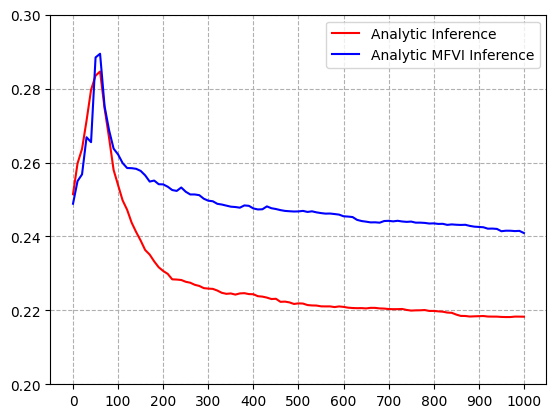

In [4]:
ai_data = [
    [0.2512457405412507, 0.2509806051512021, 0.24958107650407288, 0.2479429150531651, 0.24475839962052212, 0.2437023972025146, 0.24349304997279808, 0.24038770880307994, 0.23949783862578156, 0.2377612081547265, 0.23761919419662436, 0.23643390354100463, 0.23671545625415816, 0.23463719853194903, 0.2350134282029422, 0.2346286817209968, 0.23507280567219704, 0.2337644928911852, 0.2299164279781189, 0.22992060240413775, 0.22905354414394008, 0.22809001238345458, 0.2279119877889988, 0.22772227673595716, 0.2275837936769195, 0.22733482719818043, 0.22651680569480162, 0.22620067530867655, 0.2270877274837626, 0.22771117109907804, 0.22800197216486018, 0.22812863628676974, 0.22767091352775368, 0.22757699485155095, 0.2277693827867936, 0.22804418558989803, 0.22738057898607508, 0.22805715790605274, 0.22810153156955396, 0.22832107332362278, 0.22817756586488927, 0.2275544696198735, 0.22763197688429737, 0.22740258715658407, 0.2269577775750786, 0.22703115309144148, 0.22650266750188072, 0.22627813908219563, 0.22596895290740732, 0.22526334588823574, 0.22525157404189802, 0.22500032950483143, 0.22506197169188125, 0.22523547134370758, 0.22550887065872446, 0.22509836030597594, 0.22518096404869686, 0.22526870039392236, 0.22490437773009636, 0.22498530155491542, 0.22527386287240922, 0.22494174226373245, 0.22487616403309185, 0.22497168294947673, 0.22513880762842264, 0.22529712172683297, 0.22536090583760052, 0.225588555560092, 0.22548083119002849, 0.2255345863453879, 0.22545650461085393, 0.2254359685233997, 0.2256647792842417, 0.2256504016219254, 0.2257310591194264, 0.22529674080219608, 0.22524504370534196, 0.2255081541189979, 0.2254413032348412, 0.22465838636039717, 0.2246195024890704, 0.22443284702815852, 0.2244603664399825, 0.22425671539543274, 0.2238302453491546, 0.22358348314771018, 0.22320189826903278, 0.2231144663784614, 0.22309574520973147, 0.22306242809684623, 0.22321401742668376, 0.22318634032047246, 0.22289251196885163, 0.2227991891445561, 0.2229178387715075, 0.22303718026866293, 0.2229607350032286, 0.2229715790278409, 0.2231410530363494, 0.22298785957937406, 0.22268998506601043],
    [0.25110021447795794, 0.26247153345796986, 0.26264917498244217, 0.2725773897081835, 0.2834668278772494, 0.2903508446277955, 0.29520236984686965, 0.29105636810403224, 0.2791670157435118, 0.27105541047405135, 0.2622783308226922, 0.25803531476007324, 0.2556519337760595, 0.24986235541085164, 0.24631568145052454, 0.24158954509430638, 0.23619773254275198, 0.23436693060653047, 0.23354844604870295, 0.2307339977737415, 0.23084693206457146, 0.2304899919451414, 0.22899404619214891, 0.2286737218325434, 0.22834802491428305, 0.22690534038857854, 0.22675097322097415, 0.22555659849205537, 0.22430979977329962, 0.2234406404714696, 0.22325820319129555, 0.22258370625121787, 0.22188547041996687, 0.22144687932904047, 0.22104967479479118, 0.22171740892151212, 0.2213735411395054, 0.2217241548036713, 0.22164878381093853, 0.22100493293107182, 0.22096613977568638, 0.22050571698932342, 0.21992594998583695, 0.21970005638736492, 0.21925185504854963, 0.2194498187556532, 0.21930388595088313, 0.22006862909416022, 0.21996820657920127, 0.2191270043803155, 0.21925615713941188, 0.21914958619207695, 0.21889579548673108, 0.21875079368447323, 0.21866591460352564, 0.21870581532697506, 0.21831276829766125, 0.21819589956785695, 0.21827249929681886, 0.2184497024118497, 0.21826288747589775, 0.21824742372266018, 0.2178990590681372, 0.21765617814237417, 0.21787710431954507, 0.21782253120780717, 0.21803363738270862, 0.21823785821059474, 0.21805461515263, 0.21794960726557977, 0.2177585487045343, 0.21740644587038732, 0.2173823360633256, 0.21707100691794967, 0.21683818731169915, 0.2166143801639965, 0.21674092464961192, 0.21639819168897118, 0.21668574819415093, 0.2165760802487643, 0.2167441194477968, 0.2167920020853156, 0.216324780670799, 0.21629692809877168, 0.21664393969206916, 0.2167059562223654, 0.21628484182871116, 0.21619174401914, 0.21605368559857985, 0.21611349891344805, 0.21598953885336378, 0.2160429662250314, 0.21614892491592358, 0.21598572339675554, 0.21588428781273317, 0.21584269808431022, 0.2156453185307667, 0.2154570626235088, 0.21571074740693785, 0.21571908232878687, 0.21587306053469923],
    [0.2519171464174956, 0.26580938679414545, 0.27884139942861574, 0.29344438657307065, 0.3107297491071773, 0.316487405499272, 0.31516001622791734, 0.29250016875955004, 0.2812654202620865, 0.265163154201953, 0.26169116484611094, 0.25480309863474543, 0.24927290870279722, 0.2467134055391651, 0.24223769904873102, 0.24044981046951955, 0.23771585232485695, 0.23715032000133038, 0.23628064686436256, 0.23433838896590672, 0.23206102634067846, 0.23103925048647111, 0.22828168790907116, 0.22860899958196115, 0.2287172141004671, 0.22895313274966944, 0.22916029181428035, 0.22898609529575922, 0.22842423592817804, 0.22689567780646247, 0.22640133904922102, 0.2267198536988623, 0.2265319944483412, 0.22521614287248753, 0.22460158757517446, 0.22396053923710751, 0.22403797695400943, 0.22396150638432089, 0.2241969131522653, 0.2238770694392078, 0.22393388516667656, 0.22342397575796719, 0.22360604329839479, 0.22324877931703258, 0.22298061360139187, 0.22291426047217844, 0.22113032195833793, 0.22075300066454065, 0.22052586751701714, 0.22079808958590252, 0.22116438642441255, 0.22137033386310065, 0.22035108178134816, 0.22000311163305675, 0.21972574021113497, 0.21946108944361303, 0.21970972790327634, 0.21975404357227782, 0.2194916671744047, 0.21976377848891268, 0.2192780555556567, 0.21900286841582492, 0.21912665231259099, 0.2191299603429029, 0.21881927313260366, 0.21845695461362227, 0.21863933094006735, 0.218183173939618, 0.2180377964930374, 0.21796890792567503, 0.2178445292475182, 0.21812455253227267, 0.21793625968052865, 0.21839422702705005, 0.21776550167934497, 0.21790414913055922, 0.21801913265823164, 0.21815762284080104, 0.2181358241480667, 0.21829333937746112, 0.2181766614317182, 0.217969964650916, 0.21812565537274997, 0.21765815853424086, 0.21752644221392542, 0.21626509486970544, 0.21599917858903608, 0.21611983987308425, 0.2158452336321241, 0.21598095089308603, 0.2160676241381008, 0.21618629810564907, 0.2159428951180151, 0.2161460807363787, 0.21611300301997172, 0.2157815935158395, 0.215955019051126, 0.21614765362689287, 0.2160833539799706, 0.21620581959471047, 0.21628698762542967]
]
mfvi_data = [
    [0.2512562174620849, 0.251588243652858, 0.2523294785942968, 0.2536487478622731, 0.25649159738560434, 0.2569535296614683, 0.2583036055308438, 0.25668899536440304, 0.2594172264564455, 0.26152671425143337, 0.26071681389152074, 0.26006761522678307, 0.26439035804815764, 0.26610137052258337, 0.2663328762822373, 0.26569012771128997, 0.26581066844747786, 0.263382627444629, 0.2641388060883134, 0.26326954821381904, 0.2648723191417712, 0.2640417156278631, 0.26151270074435057, 0.2616170810096973, 0.26130915520531656, 0.25888230368102594, 0.2578310747518252, 0.25832840999300755, 0.25749865420462015, 0.2560292779601398, 0.25456184728788356, 0.2542342106127763, 0.253935332412726, 0.25371382202670045, 0.2533491639494817, 0.25304288231955324, 0.2519560287615798, 0.25099608799366896, 0.25280250278694677, 0.2524689418085151, 0.25108218693294776, 0.25076425236885996, 0.25060540968892997, 0.2527710087211032, 0.2517323085133488, 0.2513495734361983, 0.250907824100028, 0.25052461770438395, 0.24999186506387366, 0.24991085858881879, 0.24977180764925724, 0.2498261996576828, 0.24953905165771315, 0.25116566120251055, 0.25095324900838845, 0.25042637512843985, 0.24976539437596876, 0.25008246949845475, 0.2497959801368006, 0.24960728600333795, 0.24860786617536376, 0.2484101452240712, 0.2482338115872794, 0.24591610907820294, 0.24558656388863198, 0.24547261064724188, 0.24515750641072348, 0.24540615596402687, 0.24520377672532154, 0.24662916880050656, 0.247078252172947, 0.24685644388115663, 0.24705154827769993, 0.24647222175924408, 0.2461477966058101, 0.24666528603021332, 0.24697594481873544, 0.24647456077709118, 0.2462570105004974, 0.2462198961320586, 0.24654504355943388, 0.24615054082599916, 0.24621012621429234, 0.2457007950955833, 0.24615871546083162, 0.24607971649362556, 0.24594215169576647, 0.24550765290539636, 0.24494790916975495, 0.24476177120249273, 0.2447599518596691, 0.24464689895704025, 0.24452090229407109, 0.24461905569379414, 0.24461904777961554, 0.24441829284255326, 0.24456681636254426, 0.24454916583355524, 0.24443405331527662, 0.24420951879508995, 0.24244592488444205],
    [0.24918521824374018, 0.24845118393549706, 0.24778748261638758, 0.2472573213602224, 0.24614784799968267, 0.24605380004199529, 0.24538357637781963, 0.24522800668916261, 0.24516171626165723, 0.2447921755283559, 0.2447011738314455, 0.24450195214988069, 0.24452583606320802, 0.24475810238418816, 0.24467597663413979, 0.24537235302500632, 0.24502355715324206, 0.2450893064166856, 0.24493550522155755, 0.24462150278062259, 0.24450657768216827, 0.24448623632918437, 0.24441121391598325, 0.24419426785676515, 0.244189295988408, 0.2440571849991578, 0.24392337261461308, 0.24390697477674111, 0.24376946270830702, 0.24374816811680172, 0.24366872891972388, 0.2434652592473995, 0.2427717591108767, 0.24281268964487573, 0.24266658401837182, 0.24268932044962277, 0.2424694879744084, 0.24270503670959892, 0.24278318069560403, 0.24272034957238825, 0.24262164783078255, 0.24243335295688076, 0.24237338789845916, 0.24249521504430085, 0.2424966094969643, 0.2425693556522741, 0.2421125191074789, 0.24217393981380195, 0.24217661395802662, 0.24209429547893602, 0.24257214705861324, 0.2426263249914829, 0.24259178221952524, 0.24247434779294894, 0.24232696724977346, 0.24221433171443274, 0.24221931030066893, 0.24211508371886017, 0.24204600134188228, 0.24198622444447604, 0.2417863855012527, 0.24185369597854792, 0.24190897341733797, 0.24184200130766487, 0.24170307602272473, 0.24168600214416852, 0.24157395945382845, 0.24139199156889488, 0.24137939667216293, 0.24111988867864081, 0.24101957731545898, 0.24094110282846312, 0.24089708199513238, 0.24098904756137862, 0.24081702929112675, 0.24082798684817316, 0.24074704641588274, 0.24065371980564257, 0.2404807905587192, 0.2401918315749992, 0.24004013735202293, 0.24004412030943267, 0.24004399099109186, 0.24002687128952882, 0.24005124025920319, 0.23985629070685302, 0.23972829447197233, 0.2398034700945947, 0.23953567182287863, 0.23941690242537528, 0.23930670398897344, 0.23925030466935263, 0.23836481260825917, 0.2383358373932796, 0.2383151083382549, 0.23818456342373856, 0.2381887902350253, 0.23816027534706002, 0.23818370890346746, 0.23828022030467194, 0.2381928667691559],
    [0.24610438961220352, 0.2648635423674603, 0.2702685609243311, 0.2995980451010778, 0.29386729858509925, 0.3622888454146799, 0.3645979974090103, 0.32374777156107076, 0.3015946908480983, 0.2849625926314167, 0.28108443431674435, 0.27500686612660885, 0.2666124584075811, 0.26454427383547274, 0.26387759988318077, 0.26214024718348844, 0.2587716094129441, 0.25606960035204646, 0.2562757571789641, 0.25450279152618893, 0.25285195120868953, 0.25184473220287174, 0.25174199364137395, 0.25112728306599796, 0.25423386726846825, 0.253332493920776, 0.25231510814710617, 0.25183512295815635, 0.2522328723805291, 0.25084042215521934, 0.2507833595258457, 0.2508581011088485, 0.2497740950545778, 0.2493728581769169, 0.24900046631183392, 0.24842575049297044, 0.24945384017884825, 0.24964320968051065, 0.24959085045789178, 0.2496551949964238, 0.24901609027151503, 0.24869823680171366, 0.24906754404127202, 0.2491208948006727, 0.2486686030875823, 0.2483316275860195, 0.248349139602335, 0.24802885246103368, 0.24828369677174053, 0.24822725678569738, 0.24797292016217928, 0.24828125295765074, 0.2477607668818774, 0.24675430095831685, 0.2462619327810296, 0.2463116041669064, 0.2465300829213385, 0.24639393247249217, 0.24633486123013382, 0.24612614385630632, 0.2459686476918433, 0.24585712751119507, 0.24559327943317277, 0.24567838012102902, 0.24521311342759933, 0.24483132168813557, 0.24466793729450434, 0.24466648620560702, 0.24457667530058846, 0.2447589845459732, 0.24457602684852792, 0.24443433812904783, 0.2447482257969641, 0.24467762270658247, 0.24485918786335856, 0.24456644408245476, 0.24347218581007937, 0.24407029096254626, 0.2442446775530021, 0.24406330590108946, 0.24402164381994457, 0.24396652773009547, 0.24399600662027865, 0.24365092090015414, 0.24355946932016423, 0.2435491129637204, 0.2436601430912908, 0.24414702772854238, 0.24406667399531026, 0.2437630874250347, 0.24363820377150547, 0.2435553963486452, 0.24341851466216466, 0.24342224845071578, 0.24317642174131904, 0.24163728787534872, 0.2418969334556614, 0.24191414106809084, 0.24172191141893193, 0.24202487251050625, 0.24211374831950463]
]


plot_data = [
    {"data": ai_data, "label": "Analytic Inference", "color": "red"},
    {"data": mfvi_data, "label": "Analytic MFVI Inference", "color": "blue"},
]

plot_graph(plot_data, std=False)